# NexusTrader FYP — Experiment Notebook
## 3 Tickers × 3 Dates × 3 Horizons | Memory OFF (Policy A) | Baseline Comparison

This notebook runs the full evaluation pipeline:
1. **Baselines** (Buy&Hold, SMA, RSI, Random) — runs locally, no backend needed
2. **NexusTrader agent** — calls the backend API (must be running on `localhost:8000`)
3. **Scoring** — fetches k-day forward returns via yfinance
4. **Charts** — accuracy, coverage, returns distribution, heatmaps

**Total runs:** 3 tickers × 3 dates × 3 horizons = **27 runs per strategy** → 135 total

## 1. Setup and Configuration

In [4]:
import os
import sys
import json
import time
import itertools
from datetime import datetime, timedelta
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import yfinance as yf

# -- Paths --
NOTEBOOK_DIR = Path(os.getcwd()) if "__file__" not in dir() else Path(__file__).parent
EXPERIMENTS_DIR = Path(r"c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments")
RAW_DIR = EXPERIMENTS_DIR / "results" / "raw"
SCORED_DIR = EXPERIMENTS_DIR / "results" / "scored"
CHARTS_DIR = EXPERIMENTS_DIR / "charts"

for d in [RAW_DIR, SCORED_DIR, CHARTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# -- API --
API_BASE = "http://localhost:8000"
ANALYZE_URL = f"{API_BASE}/analyze"
BASELINE_URL = f"{API_BASE}/baseline"

# -- Plot style --
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 120

print("✅ Setup complete")

✅ Setup complete


## 2. Define Experiment Matrix (5 Tickers × 5 Dates × 3 Horizons)

In [5]:
# --- Load Experiment Parameters from Files ---
INPUTS_DIR = EXPERIMENTS_DIR / "inputs"

# Load tickers from file
TICKERS_FILE = INPUTS_DIR / "tickers.txt"
with open(TICKERS_FILE, "r") as f:
    TICKERS = [line.strip() for line in f if line.strip()]

# Load dates from file
DATES_FILE = INPUTS_DIR / "dates_expanded.txt"
with open(DATES_FILE, "r") as f:
    SIMULATED_DATES = [line.strip() for line in f if line.strip()]

# Horizon labels → k trading days
HORIZONS = {
    "short":  10,
}

BASELINE_NAMES = ["buy_hold", "sma", "rsi", "random"]

# Build the full matrix
matrix = list(itertools.product(TICKERS, SIMULATED_DATES, HORIZONS.keys()))

print(f"✅ Loaded from files:")
print(f"  Tickers file:    {TICKERS_FILE}")
print(f"  Tickers:         {TICKERS}")
print(f"\n  Dates file:      {DATES_FILE}")
print(f"  Dates:           {SIMULATED_DATES}")
print(f"\n  Horizons:        {list(HORIZONS.keys())} → k = {list(HORIZONS.values())}")
print(f"  Matrix:          {len(matrix)} runs per strategy")
print(f"  Strategies:      NexusTrader + {len(BASELINE_NAMES)} baselines = {1 + len(BASELINE_NAMES)}")
print(f"  Total runs:      {len(matrix) * (1 + len(BASELINE_NAMES))}")

✅ Loaded from files:
  Tickers file:    c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\inputs\tickers.txt
  Tickers:         ['AAPL', 'NVDA', 'JNJ', 'JPM', 'XOM']

  Dates file:      c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\inputs\dates_expanded.txt
  Dates:           ['2021-09-13', '2021-10-04', '2021-10-25', '2021-11-15', '2021-12-06', '2021-12-27', '2022-01-17', '2022-02-07', '2022-02-28', '2022-03-21', '2022-04-11', '2022-05-02', '2022-05-23', '2022-06-13', '2022-07-04', '2022-07-25', '2022-08-15', '2022-09-05', '2022-09-26', '2022-10-17', '2022-11-07', '2022-11-28', '2022-12-19', '2023-01-09', '2023-01-30', '2023-02-20', '2023-03-13', '2023-04-03', '2023-04-24', '2023-05-15', '2023-06-05', '2023-06-26', '2023-07-17', '2023-08-07', '2023-08-28', '2023-09-18', '2023-10-09', '2023-10-30', '2023-11-20', '2023-12-11', '2024-01-01', '2024-01-22', '2024-02-12', '2024-03-04', '2

## 3. Run Baseline Strategies (B1–B4)

Calls `POST /baseline` for each `(ticker, date, horizon)`.  
**No backend needed** for baselines, but using the API keeps the scoring path consistent.  
If the backend isn't running, use the **offline fallback** cell below instead.

In [10]:
# ====  Run baselines via API  ====
baseline_results = []
total = len(BASELINE_NAMES) * len(matrix)
done = 0

BASELINE_WORKERS = 100
USE_PARALLEL_BASELINES = True

def _baseline_call(bl_name: str, ticker: str, sim_date: str, horizon: str) -> dict:
    payload = {
        "ticker": ticker,
        "baseline": bl_name,
        "simulated_date": sim_date,
    }
    try:
        resp = requests.post(BASELINE_URL, json=payload, timeout=30)
        data = resp.json()
    except Exception as e:
        data = {"error": str(e)}
    return {
        "strategy": bl_name,
        "ticker": ticker,
        "simulated_date": sim_date,
        "horizon": horizon,
        "k": HORIZONS[horizon],
        "action": data.get("trading_strategy", {}).get("action", "HOLD"),
        "entry_price": data.get("trading_strategy", {}).get("entry_price"),
        "rationale": data.get("trading_strategy", {}).get("rationale", ""),
        "raw": data,
    }

if USE_PARALLEL_BASELINES:
    tasks = [(bl, t, d, h) for bl in BASELINE_NAMES for (t, d, h) in matrix]
    with ThreadPoolExecutor(max_workers=BASELINE_WORKERS) as ex:
        futures = [ex.submit(_baseline_call, *task) for task in tasks]
        for i, fut in enumerate(as_completed(futures), start=1):
            baseline_results.append(fut.result())
            if i % 200 == 0 or i == total:
                print(f"  Baselines: {i}/{total} done")
else:
    for bl_name in BASELINE_NAMES:
        for ticker, sim_date, horizon in matrix:
            baseline_results.append(_baseline_call(bl_name, ticker, sim_date, horizon))
            done += 1
            if done % 100 == 0 or done == total:
                print(f"  Baselines: {done}/{total} done")

# Save raw JSONL
bl_path = RAW_DIR / "baselines_sample.jsonl"
with open(bl_path, "w") as f:
    for r in baseline_results:
        f.write(json.dumps(r, default=str) + "\n")

print(f"\n✅ {len(baseline_results)} baseline runs saved → {bl_path}")

  Baselines: 200/1540 done
  Baselines: 400/1540 done
  Baselines: 600/1540 done
  Baselines: 800/1540 done
  Baselines: 1000/1540 done
  Baselines: 1200/1540 done
  Baselines: 1400/1540 done
  Baselines: 1540/1540 done

✅ 1540 baseline runs saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\results\raw\baselines_sample.jsonl


### 3b. Offline Fallback — Run Baselines Without Backend

Use this cell **only if the backend isn't running**. It imports the baseline classes directly.

In [ ]:
# ====  Offline fallback: import baselines directly  ====
# Uncomment and run this cell INSTEAD of section 3 if backend is not running.

import sys
sys.path.insert(0, str(EXPERIMENTS_DIR.parent / "backend"))
from app.baselines.strategies import get_baseline

baseline_results = []
total = len(BASELINE_NAMES) * len(matrix)
done = 0

for bl_name in BASELINE_NAMES:
    try:
        strategy = get_baseline(bl_name)
        for ticker, sim_date, horizon in matrix:
            data = strategy.generate_signal(ticker, sim_date)
            baseline_results.append({
                "strategy": bl_name,
                "ticker": ticker,
                "simulated_date": sim_date,
                "horizon": horizon,
                "k": HORIZONS[horizon],
                "action": data.get("trading_strategy", {}).get("action", "HOLD"),
                "entry_price": data.get("trading_strategy", {}).get("entry_price"),
                "rationale": data.get("trading_strategy", {}).get("rationale", ""),
                "raw": data,
            })
            done += 1
            if done % 25 == 0 or done == total:
                print(f"  Baselines: {done}/{total} done")
    except Exception as e:
        print(f"Error initializing baseline {bl_name}: {e}")

bl_path = RAW_DIR / "baselines_sample.jsonl"
with open(bl_path, "w") as f:
    for r in baseline_results:
        f.write(json.dumps(r, default=str) + "\n")
print(f"✅ {len(baseline_results)} baseline runs saved → {bl_path}")

## 4. Run NexusTrader Agent (Policy A — Memory Off)

⚠️ **Backend must be running:** `cd nexustrader/backend && uvicorn app.main:app --reload`

Each call takes ~30–60s. Estimated time: **75 × 45s ≈ 56 minutes**.  
Progress is printed every 5 runs.

In [ ]:
# ====  Run NexusTrader via API  ====
agent_results = []
total = len(matrix)
done = 0
start_all = time.time()

for ticker, sim_date, horizon in matrix:
    payload = {
        "ticker": ticker,
        "simulated_date": sim_date,
        "horizon": horizon,
        "debate_rounds": 1,
        "memory_on": False,   # Policy A: no memory
        "risk_on": True,
        "social_on": False,
    }
    t0 = time.time()
    try:
        resp = requests.post(ANALYZE_URL, json=payload, timeout=300)
        data = resp.json()
        elapsed = time.time() - t0
    except Exception as e:
        data = {"error": str(e)}
        elapsed = time.time() - t0

    # Extract trading strategy from response
    ts = data.get("trading_strategy", data.get("result", {}).get("trading_strategy", {}))
    action = ts.get("action", "HOLD") if isinstance(ts, dict) else "HOLD"

    agent_results.append({
        "strategy": "NexusTrader",
        "ticker": ticker,
        "simulated_date": sim_date,
        "horizon": horizon,
        "k": HORIZONS[horizon],
        "action": action,
        "entry_price": ts.get("entry_price") if isinstance(ts, dict) else None,
        "rationale": ts.get("rationale", "") if isinstance(ts, dict) else "",
        "elapsed_s": round(elapsed, 1),
        "raw": data,
    })
    done += 1
    remaining = (time.time() - start_all) / done * (total - done)
    if done % 5 == 0 or done == total:
        print(f"  NexusTrader: {done}/{total} done  |  last: {elapsed:.0f}s  |  ETA: {remaining/60:.1f} min")

# Save raw JSONL
agent_path = RAW_DIR / "nexustrader_sample.jsonl"
with open(agent_path, "w") as f:
    for r in agent_results:
        f.write(json.dumps(r, default=str) + "\n")

print(f"\n✅ {len(agent_results)} agent runs saved → {agent_path}")
print(f"   Total time: {(time.time()-start_all)/60:.1f} min")

### 4b. Load Results from Parallel Batch Runner (Optional)

If you ran `run_batch.py` with multiple workers, load the JSONL output here instead of running Section 4.

In [11]:
# ---- Load agent runs from a batch JSONL file ----
# Set this to your batch output file from run_batch.py
BATCH_JSONL = RAW_DIR / "batch_frozen_set_v4_20260213_144511.jsonl"

if BATCH_JSONL.exists():
    agent_results = []
    with open(BATCH_JSONL, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            row = json.loads(line)
            ts = row.get("trading_strategy", row.get("result", {}).get("trading_strategy", {}))
            action = ts.get("action", "HOLD") if isinstance(ts, dict) else "HOLD"
            agent_results.append({
                "strategy": "NexusTrader",
                "ticker": row.get("ticker"),
                "simulated_date": row.get("simulated_date"),
                "horizon": row.get("horizon", "short"),
                "k": HORIZONS.get(row.get("horizon", "short"), 10),
                "action": action,
                "entry_price": ts.get("entry_price") if isinstance(ts, dict) else None,
                "rationale": ts.get("rationale", "") if isinstance(ts, dict) else "",
                "raw": row,
            })

    print(f"✅ Loaded {len(agent_results)} agent runs from {BATCH_JSONL}")
else:
    print(f"⚠️ Batch file not found: {BATCH_JSONL}")

✅ Loaded 385 agent runs from c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\results\raw\batch_frozen_set_v4_20260213_144511.jsonl


## 5. Score Results — Fetch Forward Returns & Compute Metrics

For each run, we fetch the actual closing price on `simulated_date` and `k` trading days later via **yfinance**, then compute:
- **Forward return** $r_k = \frac{P_{t+k} - P_t}{P_t}$
- **Strategy return**: BUY → $r_k$, SELL → $-r_k$, HOLD → $0$
- **Directional accuracy**: BUY correct if $r_k > 0$, SELL correct if $r_k < 0$

In [12]:
# --- HOLD Scoring Configuration ---
# Neutral-band approach: HOLD is correct when |k_return| < epsilon
# This is fairer than excluding HOLDs entirely, as it credits correct "do nothing" decisions
HOLD_EPSILON = 0.025  # 2.5% threshold - HOLD correct if market moves < 2.5%

# --- Suppress yfinance noise ---
import logging
logging.getLogger('yfinance').setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Cache for yfinance history (avoids duplicate fetches)
from functools import lru_cache
from typing import Tuple, Optional

@lru_cache(maxsize=512)
def fetch_ticker_history_cached(ticker: str, start_str: str, end_str: str) -> Tuple[Optional[list], Optional[str]]:
    """Cached ticker history fetch. Returns (closes_list, error_msg)."""
    try:
        start = datetime.fromisoformat(start_str)
        end = datetime.fromisoformat(end_str)
        
        # Skip future dates (can't get data for dates that haven't occurred)
        if start > datetime.now():
            return None, "future_date"
        
        hist = yf.Ticker(ticker).history(start=start, end=end, auto_adjust=True)
        if hist.empty:
            return None, "empty_history"
        closes = hist["Close"].dropna().tolist()
        return closes, None
    except Exception as e:
        print(f"⚠️ Fetch error for {ticker} {start_str}: {e}")
        return None, "fetch_error"


def get_k_day_return(ticker: str, as_of: str, k: int) -> float | None:
    """Fetch k-day forward return from yfinance (cached)."""
    start = datetime.fromisoformat(as_of)
    end = start + timedelta(days=max(14, k * 3))
    
    closes, err = fetch_ticker_history_cached(ticker, as_of, end.isoformat())
    if closes is None:
        return None
    if len(closes) <= k:
        return None
    
    entry = float(closes[0])
    exit_price = float(closes[k])
    
    if entry == 0:
        return None
    
    return (exit_price - entry) / entry


def prefetch_all_histories(runs: list[dict], max_workers: int = 24) -> None:
    """Pre-fetch all unique ticker histories in parallel to populate cache."""
    unique_fetches = set()
    now = datetime.now()
    
    for r in runs:
        ticker = r["ticker"]
        as_of = r["simulated_date"]
        k = r["k"]
        start = datetime.fromisoformat(as_of)
        
        # Skip future dates entirely
        if start > now:
            continue
        
        end = start + timedelta(days=max(14, k * 3))
        unique_fetches.add((ticker, as_of, end.isoformat()))
    
    print(f"Pre-fetching {len(unique_fetches)} ticker histories (workers={max_workers})...")
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(fetch_ticker_history_cached, t, s, e): (t, s, e)
            for t, s, e in unique_fetches
        }
        
        completed = 0
        total = len(futures)
        for future in as_completed(futures):
            completed += 1
            if completed % 25 == 0 or completed == total:
                print(f"  {completed}/{total} ({completed/total*100:.0f}%)", end="\r")
        print(f"  {total}/{total} (100%)  ")
    
    print("✅ Pre-fetch complete. All scoring will now hit cache.")


def score_runs(runs: list[dict]) -> pd.DataFrame:
    """Score a list of run dicts → DataFrame with returns + accuracy columns.
    
    Uses neutral-band scoring for HOLD:
    - HOLD is correct if |k_return| < HOLD_EPSILON (market didn't move much)
    - BUY is correct if k_return > 0
    - SELL is correct if k_return < 0
    """
    records = []
    none_count = 0
    for r in runs:
        k_ret = get_k_day_return(r["ticker"], r["simulated_date"], r["k"])
        if k_ret is None:
            none_count += 1
        action = (r.get("action") or "HOLD").upper()

        # Strategy return
        if action == "BUY":
            strat_ret = k_ret
        elif action == "SELL":
            strat_ret = -k_ret if k_ret is not None else None
        else:
            strat_ret = 0.0

        # Directional correctness with neutral-band HOLD scoring
        if k_ret is not None:
            if action == "HOLD":
                # HOLD is correct if |k_return| < epsilon (neutral band)
                correct = 1 if abs(k_ret) < HOLD_EPSILON else 0
            elif action == "BUY":
                correct = 1 if k_ret > 0 else 0
            elif action == "SELL":
                correct = 1 if k_ret < 0 else 0
            else:
                correct = None    

        records.append({
            "strategy": r["strategy"],
            "ticker": r["ticker"],
            "simulated_date": r["simulated_date"],
            "horizon": r["horizon"],
            "k": r["k"],
            "action": action,
            "k_return": k_ret,
            "strategy_return": strat_ret,
            "correct": correct,
        })
    
    if none_count > 0:
        print(f"  ⚠️ {none_count}/{len(runs)} runs had None k_return (no price data)")
    
    return pd.DataFrame(records)


# Pre-fetch all histories in parallel (populates cache)
all_runs = baseline_results + agent_results

# DEBUG: Check if baseline actions are set
print("\n🔍 DEBUG: Checking baseline actions...")
for bl_name in ["buy_hold", "sma", "rsi", "random"]:
    sample = [r for r in baseline_results if r["strategy"] == bl_name][:3]
    if sample:
        print(f"  {bl_name}: {[r.get('action') for r in sample]}")

prefetch_all_histories(all_runs, max_workers=24)

# Score all runs (now hitting cache, very fast)
print("\nScoring baselines …")
df_baselines = score_runs(baseline_results)
print(f"  {len(df_baselines)} baseline runs scored")

print("Scoring NexusTrader …")
df_agent = score_runs(agent_results)
print(f"  {len(df_agent)} agent runs scored")

print(f"✅ Scoring complete (HOLD neutral-band: ±{HOLD_EPSILON*100:.1f}%)")


🔍 DEBUG: Checking baseline actions...
  buy_hold: ['BUY', 'BUY', 'BUY']
  sma: ['BUY', 'SELL', 'SELL']
  rsi: ['HOLD', 'HOLD', 'HOLD']
  random: ['BUY', 'SELL', 'BUY']
Pre-fetching 385 ticker histories (workers=24)...
  385/385 (100%)  
✅ Pre-fetch complete. All scoring will now hit cache.

Scoring baselines …
  ⚠️ 36/1540 runs had None k_return (no price data)
  1540 baseline runs scored
Scoring NexusTrader …
  ⚠️ 9/385 runs had None k_return (no price data)
  385 agent runs scored
✅ Scoring complete (HOLD neutral-band: ±2.5%)


## 6. Merge All Scores & Build Summary Table

In [13]:
# Merge agent + baselines into one DataFrame
df_all = pd.concat([df_agent, df_baselines], ignore_index=True)

# Save per-run scores
scores_path = SCORED_DIR / "scores_sample.csv"
df_all.to_csv(scores_path, index=False)
print(f"Per-run scores saved → {scores_path}")

# --- Compute aggregate metrics per strategy ---
def compute_summary(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for strategy, grp in df.groupby("strategy"):
        non_hold = grp[grp["action"] != "HOLD"]
        scored = non_hold.dropna(subset=["correct"])
        rows.append({
            "strategy": strategy,
            "total_runs": len(grp),
            "non_hold": len(non_hold),
            "coverage_%": round(len(non_hold) / len(grp) * 100, 1) if len(grp) > 0 else 0,
            "scored": len(scored),
            "accuracy_%": round(scored["correct"].mean() * 100, 1) if len(scored) > 0 else None,
            "mean_return_%": round(scored["strategy_return"].mean() * 100, 2) if len(scored) > 0 else None,
            "std_return_%": round(scored["strategy_return"].std() * 100, 2) if len(scored) > 0 else None,
        })
    return pd.DataFrame(rows).sort_values("accuracy_%", ascending=False)

summary = compute_summary(df_all)
summary_path = SCORED_DIR / "summary_sample.csv"
summary.to_csv(summary_path, index=False)

print(f"\nSummary saved → {summary_path}\n")
display(summary)

Per-run scores saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\results\scored\scores_sample.csv

Summary saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\results\scored\summary_sample.csv



,strategy,total_runs,non_hold,coverage_%,scored,accuracy_%,mean_return_%,std_return_%
1,buy_hold,385,385,100.0,385,59.0,1.42,6.15
0,NexusTrader,385,381,99.0,381,57.7,0.90,6.26
4,sma,385,374,97.1,374,53.7,0.31,6.34
2,random,385,385,100.0,385,48.6,-0.17,6.31
3,rsi,385,56,14.5,56,41.1,-1.39,5.52


## 6b. Deep-Dive Performance Analysis

Breakdown of NexusTrader vs baselines across multiple dimensions:
1. **Per-ticker accuracy** — which sectors does the agent handle best?
2. **Action distribution** — BUY/SELL/HOLD split & per-action accuracy
3. **Temporal analysis** — performance by year, rolling accuracy
4. **Market regime** — bull vs bear vs sideways periods
5. **Statistical significance** — binomial test vs random
6. **Win/loss magnitude** — average gain vs average loss (risk-adjusted quality)

In [19]:
from scipy import stats

print("=" * 70)
print("  DEEP-DIVE PERFORMANCE ANALYSIS")
print("=" * 70)

# ────────────────────────────────────────────
# 1. PER-TICKER ACCURACY — ALL STRATEGIES
# ────────────────────────────────────────────
print("\n📊 1. PER-TICKER ACCURACY (all strategies, non-HOLD scored runs)")
print("-" * 70)

df_scored = df_all[df_all["correct"].notna()].copy()
df_nonhold = df_scored[df_scored["action"] != "HOLD"]

pivot_acc = df_nonhold.groupby(["ticker", "strategy"])["correct"].agg(["mean", "count"])
pivot_acc.columns = ["accuracy", "n"]
pivot_acc["accuracy"] = (pivot_acc["accuracy"] * 100).round(1)

strat_order = ["NexusTrader", "buy_hold", "sma", "rsi", "random"]
print(f"  {'Ticker':<8s}", end="")
for s in strat_order:
    print(f"  {s:>14s}", end="")
print()
print("  " + "-" * 78)

for ticker in sorted(df_all["ticker"].unique()):
    print(f"  {ticker:<8s}", end="")
    for s in strat_order:
        key = (ticker, s)
        if key in pivot_acc.index:
            acc = pivot_acc.loc[key, "accuracy"]
            n = int(pivot_acc.loc[key, "n"])
            print(f"  {acc:>5.1f}% ({n:>3d})", end="")
        else:
            print(f"  {'N/A':>14s}", end="")
    print()

# ────────────────────────────────────────────
# 2. ACTION DISTRIBUTION — NexusTrader
# ────────────────────────────────────────────
print(f"\n📊 2. NexusTrader ACTION DISTRIBUTION & PER-ACTION ACCURACY")
print("-" * 70)

df_nt = df_all[df_all["strategy"] == "NexusTrader"].copy()
for action in ["BUY", "SELL", "HOLD"]:
    subset = df_nt[df_nt["action"] == action]
    n_total = len(subset)
    pct = n_total / len(df_nt) * 100
    scored = subset.dropna(subset=["correct"])
    n_correct = int(scored["correct"].sum()) if len(scored) > 0 else 0
    acc = scored["correct"].mean() * 100 if len(scored) > 0 else float("nan")
    mean_ret = scored["strategy_return"].mean() * 100 if len(scored) > 0 else float("nan")
    print(f"  {action:<6s}: {n_total:>4d} runs ({pct:>5.1f}%)  |  Accuracy: {acc:>5.1f}%  |  Correct: {n_correct}/{len(scored)}  |  Mean ret: {mean_ret:>+6.2f}%")

# BUY vs SELL breakdown per ticker for NexusTrader
print(f"\n  Per-ticker BUY/SELL split (NexusTrader):")
print(f"  {'Ticker':<8s} {'BUY':>5s} {'SELL':>5s} {'HOLD':>5s} {'BUY%':>6s} {'SELL%':>6s} {'BUY acc':>8s} {'SELL acc':>9s}")
print("  " + "-" * 60)
for ticker in sorted(df_nt["ticker"].unique()):
    t = df_nt[df_nt["ticker"] == ticker]
    buys = (t["action"] == "BUY").sum()
    sells = (t["action"] == "SELL").sum()
    holds = (t["action"] == "HOLD").sum()
    buy_pct = buys / len(t) * 100
    sell_pct = sells / len(t) * 100
    
    buy_scored = t[(t["action"] == "BUY") & t["correct"].notna()]
    sell_scored = t[(t["action"] == "SELL") & t["correct"].notna()]
    buy_acc = buy_scored["correct"].mean() * 100 if len(buy_scored) > 0 else float("nan")
    sell_acc = sell_scored["correct"].mean() * 100 if len(sell_scored) > 0 else float("nan")
    
    print(f"  {ticker:<8s} {buys:>5d} {sells:>5d} {holds:>5d} {buy_pct:>5.1f}% {sell_pct:>5.1f}% {buy_acc:>7.1f}% {sell_acc:>8.1f}%")

# ────────────────────────────────────────────
# 3. TEMPORAL ANALYSIS — BY YEAR
# ────────────────────────────────────────────
print(f"\n📊 3. ACCURACY BY YEAR (NexusTrader vs buy_hold, non-HOLD)")
print("-" * 70)

df_nt_scored = df_nonhold[df_nonhold["strategy"] == "NexusTrader"].copy()
df_bh_scored = df_nonhold[df_nonhold["strategy"] == "buy_hold"].copy()

df_nt_scored["year"] = pd.to_datetime(df_nt_scored["simulated_date"]).dt.year
df_bh_scored["year"] = pd.to_datetime(df_bh_scored["simulated_date"]).dt.year

print(f"  {'Year':<8s} {'NT Acc':>8s} {'NT n':>6s} {'B&H Acc':>8s} {'B&H n':>6s} {'Delta':>8s} {'NT Mean Ret':>12s}")
print("  " + "-" * 60)
for year in sorted(df_nt_scored["year"].unique()):
    nt_yr = df_nt_scored[df_nt_scored["year"] == year]
    bh_yr = df_bh_scored[df_bh_scored["year"] == year]
    
    nt_acc = nt_yr["correct"].mean() * 100 if len(nt_yr) > 0 else float("nan")
    bh_acc = bh_yr["correct"].mean() * 100 if len(bh_yr) > 0 else float("nan")
    delta = nt_acc - bh_acc
    nt_ret = nt_yr["strategy_return"].mean() * 100 if len(nt_yr) > 0 else float("nan")
    
    print(f"  {year:<8d} {nt_acc:>7.1f}% {len(nt_yr):>5d}  {bh_acc:>7.1f}% {len(bh_yr):>5d}  {delta:>+7.1f}pp {nt_ret:>+11.2f}%")

# ────────────────────────────────────────────
# 4. MARKET REGIME ANALYSIS
# ────────────────────────────────────────────
print(f"\n📊 4. PERFORMANCE BY MARKET REGIME (based on actual k_return)")
print("-" * 70)

# Classify each data point by what the market actually did
df_nt_full = df_all[(df_all["strategy"] == "NexusTrader") & df_all["k_return"].notna()].copy()

def classify_regime(k_ret):
    if k_ret > 0.03:
        return "Bull (>+3%)"
    elif k_ret < -0.03:
        return "Bear (<-3%)"
    else:
        return "Sideways (±3%)"

df_nt_full["regime"] = df_nt_full["k_return"].apply(classify_regime)

print(f"  {'Regime':<18s} {'Count':>6s} {'Accuracy':>10s} {'Mean Ret':>10s} {'Actions':>30s}")
print("  " + "-" * 78)
for regime in ["Bull (>+3%)", "Sideways (±3%)", "Bear (<-3%)"]:
    sub = df_nt_full[df_nt_full["regime"] == regime]
    scored_sub = sub.dropna(subset=["correct"])
    acc = scored_sub["correct"].mean() * 100 if len(scored_sub) > 0 else float("nan")
    ret = sub["strategy_return"].mean() * 100 if len(sub) > 0 else float("nan")
    actions = sub["action"].value_counts().to_dict()
    act_str = ", ".join(f"{k}={v}" for k, v in sorted(actions.items()))
    print(f"  {regime:<18s} {len(sub):>6d} {acc:>9.1f}% {ret:>+9.2f}% {act_str:>30s}")

# ────────────────────────────────────────────
# 5. STATISTICAL SIGNIFICANCE
# ────────────────────────────────────────────
print(f"\n📊 5. STATISTICAL SIGNIFICANCE (Binomial test: H₀ = random at 50%)")
print("-" * 70)

for strategy in strat_order:
    sub = df_nonhold[df_nonhold["strategy"] == strategy]
    n = len(sub)
    k = int(sub["correct"].sum())
    if n > 0:
        # One-sided binomial test: P(X >= k | n, p=0.5)
        p_value = 1 - stats.binom.cdf(k - 1, n, 0.5)
        acc = k / n * 100
        sig = "✅ p<0.05" if p_value < 0.05 else ("⚠️ p<0.10" if p_value < 0.10 else "❌ not sig")
        print(f"  {strategy:<14s}: {acc:>5.1f}% ({k}/{n})  p={p_value:.4f}  {sig}")

# ────────────────────────────────────────────
# 6. WIN/LOSS MAGNITUDE (Risk-adjusted quality)
# ────────────────────────────────────────────
print(f"\n📊 6. WIN/LOSS MAGNITUDE ANALYSIS")
print("-" * 70)

print(f"  {'Strategy':<14s} {'Avg Win':>8s} {'Avg Loss':>9s} {'Win/Loss':>9s} {'Max Win':>8s} {'Max Loss':>9s} {'Sharpe*':>8s}")
print("  " + "-" * 66)

for strategy in strat_order:
    sub = df_nonhold[df_nonhold["strategy"] == strategy].dropna(subset=["strategy_return"])
    if len(sub) == 0:
        continue
    wins = sub[sub["strategy_return"] > 0]["strategy_return"]
    losses = sub[sub["strategy_return"] < 0]["strategy_return"]
    
    avg_win = wins.mean() * 100 if len(wins) > 0 else 0
    avg_loss = losses.mean() * 100 if len(losses) > 0 else 0
    ratio = abs(avg_win / avg_loss) if avg_loss != 0 else float("inf")
    max_win = wins.max() * 100 if len(wins) > 0 else 0
    max_loss = losses.min() * 100 if len(losses) > 0 else 0
    
    # Approximate Sharpe (mean / std of strategy returns)
    mean_r = sub["strategy_return"].mean()
    std_r = sub["strategy_return"].std()
    sharpe = mean_r / std_r if std_r > 0 else 0
    
    print(f"  {strategy:<14s} {avg_win:>+7.2f}% {avg_loss:>+8.2f}% {ratio:>8.2f}x {max_win:>+7.2f}% {max_loss:>+8.2f}% {sharpe:>7.3f}")

# ────────────────────────────────────────────
# 7. NexusTrader WORST & BEST CALLS
# ────────────────────────────────────────────
print(f"\n📊 7. NexusTrader — TOP 5 BEST & WORST CALLS")
print("-" * 70)

df_nt_ret = df_all[(df_all["strategy"] == "NexusTrader") & df_all["strategy_return"].notna() & (df_all["action"] != "HOLD")].copy()
df_nt_ret = df_nt_ret.sort_values("strategy_return")

print("  🟢 BEST CALLS:")
for _, row in df_nt_ret.tail(5).iloc[::-1].iterrows():
    print(f"    {row['ticker']:<6s} {row['simulated_date']}  {row['action']:<5s}  ret={row['strategy_return']*100:>+6.2f}%  (mkt={row['k_return']*100:>+6.2f}%)")

print("\n  🔴 WORST CALLS:")
for _, row in df_nt_ret.head(5).iterrows():
    print(f"    {row['ticker']:<6s} {row['simulated_date']}  {row['action']:<5s}  ret={row['strategy_return']*100:>+6.2f}%  (mkt={row['k_return']*100:>+6.2f}%)")

# ────────────────────────────────────────────
# 8. CONSISTENCY — ROLLING 10-DATE ACCURACY
# ────────────────────────────────────────────
print(f"\n📊 8. NexusTrader ROLLING ACCURACY (10-date window)")
print("-" * 70)

df_nt_time = df_nonhold[df_nonhold["strategy"] == "NexusTrader"].copy()
df_nt_time["simulated_date"] = pd.to_datetime(df_nt_time["simulated_date"])
df_nt_time = df_nt_time.sort_values("simulated_date")

# Group by date (averaging across tickers per date), then rolling
date_acc = df_nt_time.groupby("simulated_date")["correct"].mean()
rolling = date_acc.rolling(window=10, min_periods=5).mean() * 100

# Show min/max/latest rolling windows
print(f"  Rolling window: 10 dates (min 5)")
if len(rolling.dropna()) > 0:
    print(f"  Peak accuracy:    {rolling.max():.1f}%  (around {rolling.idxmax().strftime('%Y-%m-%d')})")
    print(f"  Trough accuracy:  {rolling.min():.1f}%  (around {rolling.idxmin().strftime('%Y-%m-%d')})")
    print(f"  Latest accuracy:  {rolling.iloc[-1]:.1f}%  ({rolling.index[-1].strftime('%Y-%m-%d')})")
    print(f"  Std of rolling:   {rolling.std():.1f}pp")

# ────────────────────────────────────────────
# 9. HEAD-TO-HEAD: NexusTrader vs Buy&Hold per date
# ────────────────────────────────────────────
print(f"\n📊 9. HEAD-TO-HEAD: NexusTrader vs Buy&Hold (per-date wins)")
print("-" * 70)

# For each date, average accuracy across tickers
nt_by_date = df_nonhold[df_nonhold["strategy"] == "NexusTrader"].groupby("simulated_date")["correct"].mean()
bh_by_date = df_nonhold[df_nonhold["strategy"] == "buy_hold"].groupby("simulated_date")["correct"].mean()

common_dates = nt_by_date.index.intersection(bh_by_date.index)
nt_wins = 0
bh_wins = 0
ties = 0
for d in common_dates:
    if nt_by_date[d] > bh_by_date[d]:
        nt_wins += 1
    elif nt_by_date[d] < bh_by_date[d]:
        bh_wins += 1
    else:
        ties += 1

print(f"  NexusTrader won: {nt_wins}/{len(common_dates)} dates ({nt_wins/len(common_dates)*100:.1f}%)")
print(f"  Buy&Hold won:    {bh_wins}/{len(common_dates)} dates ({bh_wins/len(common_dates)*100:.1f}%)")
print(f"  Tied:            {ties}/{len(common_dates)} dates ({ties/len(common_dates)*100:.1f}%)")

# Return-based comparison
nt_ret_by_date = df_nonhold[df_nonhold["strategy"] == "NexusTrader"].groupby("simulated_date")["strategy_return"].mean()
bh_ret_by_date = df_nonhold[df_nonhold["strategy"] == "buy_hold"].groupby("simulated_date")["strategy_return"].mean()

common = nt_ret_by_date.index.intersection(bh_ret_by_date.index)
nt_ret_wins = (nt_ret_by_date[common] > bh_ret_by_date[common]).sum()
print(f"\n  Return-based: NexusTrader beat B&H on {nt_ret_wins}/{len(common)} dates ({nt_ret_wins/len(common)*100:.1f}%)")

# ────────────────────────────────────────────
# 10. CONFUSION MATRIX
# ────────────────────────────────────────────
print(f"\n📊 10. NexusTrader CONFUSION MATRIX (predicted vs actual market direction)")
print("-" * 70)

df_nt_conf = df_all[(df_all["strategy"] == "NexusTrader") & df_all["k_return"].notna()].copy()
df_nt_conf["actual"] = df_nt_conf["k_return"].apply(lambda x: "UP" if x > 0.025 else ("DOWN" if x < -0.025 else "FLAT"))
df_nt_conf["predicted"] = df_nt_conf["action"].map({"BUY": "UP", "SELL": "DOWN", "HOLD": "FLAT"})

conf = pd.crosstab(df_nt_conf["predicted"], df_nt_conf["actual"], margins=True)
print(conf.to_string())

print("\n" + "=" * 70)
print("  END DEEP-DIVE ANALYSIS")
print("=" * 70)

  DEEP-DIVE PERFORMANCE ANALYSIS

📊 1. PER-TICKER ACCURACY (all strategies, non-HOLD scored runs)
----------------------------------------------------------------------
  Ticker       NexusTrader        buy_hold             sma             rsi          random
  ------------------------------------------------------------------------------
  AAPL       57.1% ( 77)   57.1% ( 77)   48.7% ( 76)   45.5% ( 11)   41.6% ( 77)
  JNJ        54.1% ( 74)   57.1% ( 77)   55.4% ( 74)   60.0% ( 10)   46.8% ( 77)
  JPM        54.5% ( 77)   57.1% ( 77)   60.8% ( 74)   25.0% (  8)   45.5% ( 77)
  NVDA       59.2% ( 76)   61.0% ( 77)   53.3% ( 75)   29.4% ( 17)   45.5% ( 77)
  XOM        63.6% ( 77)   62.3% ( 77)   50.7% ( 75)   50.0% ( 10)   63.6% ( 77)

📊 2. NexusTrader ACTION DISTRIBUTION & PER-ACTION ACCURACY
----------------------------------------------------------------------
  BUY   :  272 runs ( 70.6%)  |  Accuracy:  62.1%  |  Correct: 169/272  |  Mean ret:  +1.65%
  SELL  :  109 runs ( 28.3%)  

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\deep_dive_analysis.png


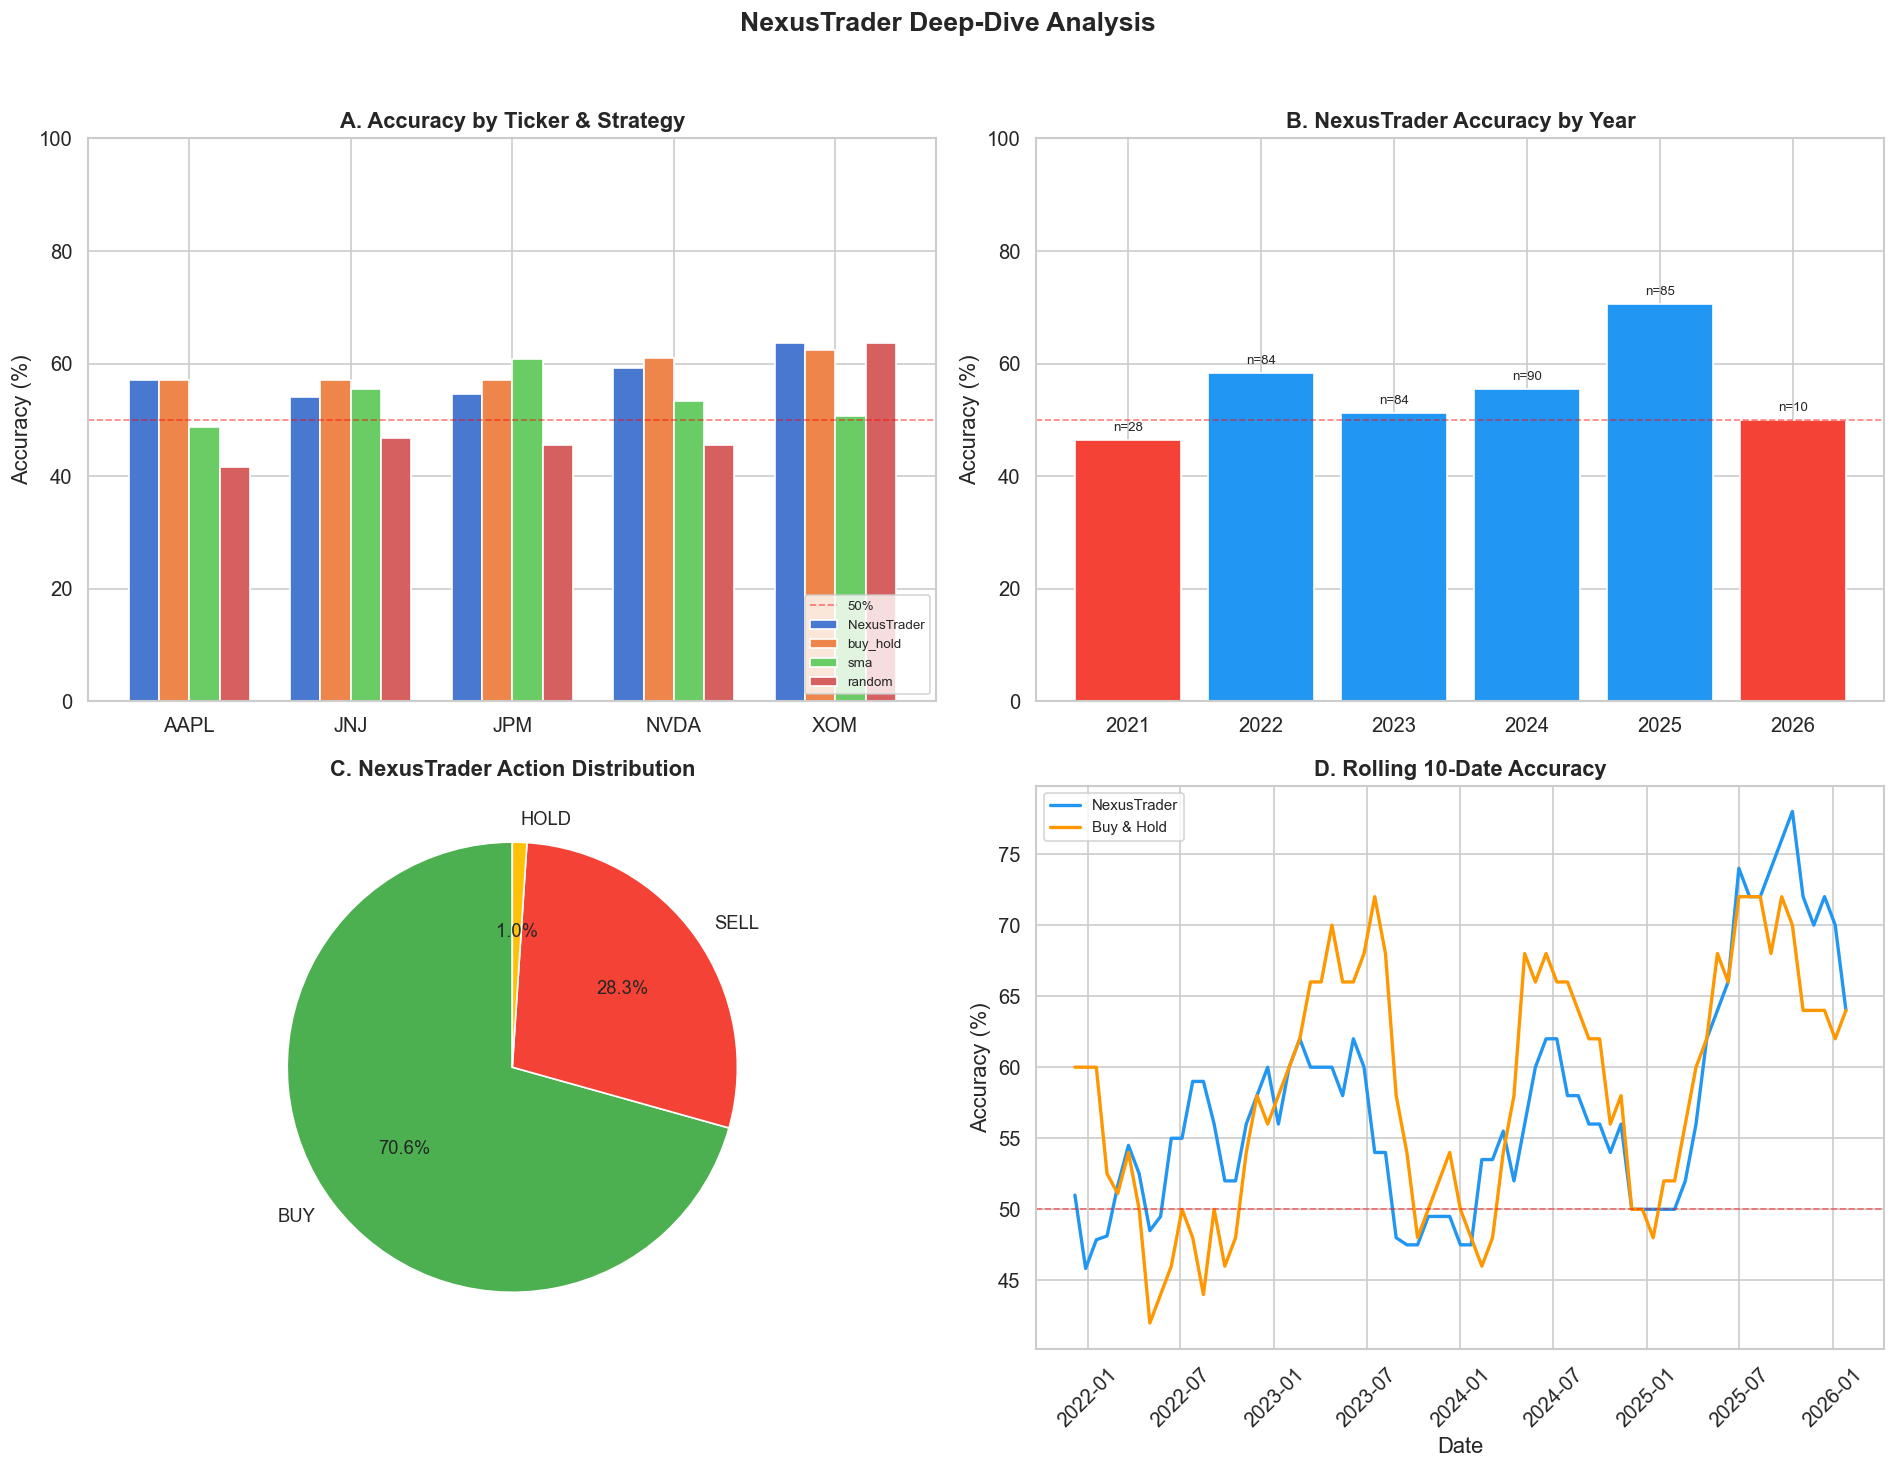

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\confusion_matrix.png


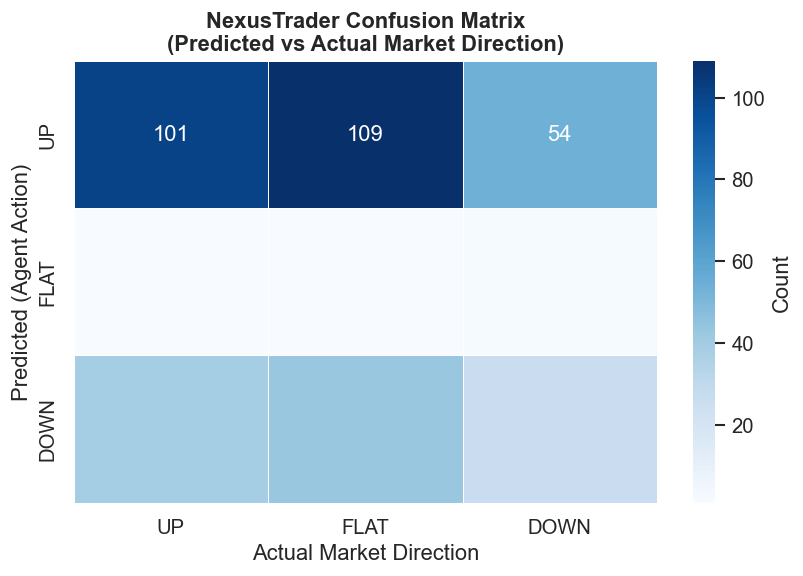

In [20]:
# ============================================================
# DEEP-DIVE VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("NexusTrader Deep-Dive Analysis", fontsize=16, fontweight="bold", y=1.02)

# --- Chart A: Per-ticker accuracy comparison ---
ax = axes[0, 0]
strategies_to_plot = ["NexusTrader", "buy_hold", "sma", "random"]
ticker_acc = df_nonhold.groupby(["ticker", "strategy"])["correct"].mean().unstack() * 100
ticker_acc = ticker_acc[[s for s in strategies_to_plot if s in ticker_acc.columns]]
ticker_acc.plot(kind="bar", ax=ax, width=0.75, edgecolor="white")
ax.axhline(50, color="red", linestyle="--", linewidth=1, alpha=0.5, label="50%")
ax.set_title("A. Accuracy by Ticker & Strategy", fontweight="bold")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(fontsize=8, loc="lower right")
ax.set_ylim(0, 100)

# --- Chart B: NexusTrader accuracy by year ---
ax = axes[0, 1]
df_nt_yr = df_nonhold[df_nonhold["strategy"] == "NexusTrader"].copy()
df_nt_yr["year"] = pd.to_datetime(df_nt_yr["simulated_date"]).dt.year
year_acc = df_nt_yr.groupby("year")["correct"].mean() * 100
year_n = df_nt_yr.groupby("year")["correct"].count()

bars = ax.bar(year_acc.index.astype(str), year_acc.values, color=["#2196F3" if a > 50 else "#F44336" for a in year_acc.values], edgecolor="white")
ax.axhline(50, color="red", linestyle="--", linewidth=1, alpha=0.5)
for bar, n in zip(bars, year_n.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"n={n}", ha="center", va="bottom", fontsize=8)
ax.set_title("B. NexusTrader Accuracy by Year", fontweight="bold")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 100)

# --- Chart C: Action distribution pie ---
ax = axes[1, 0]
df_nt_actions = df_all[df_all["strategy"] == "NexusTrader"]["action"].value_counts()
colors_pie = {"BUY": "#4CAF50", "SELL": "#F44336", "HOLD": "#FFC107"}
ax.pie(df_nt_actions.values, labels=df_nt_actions.index, 
       colors=[colors_pie.get(a, "#999") for a in df_nt_actions.index],
       autopct="%1.1f%%", startangle=90, textprops={"fontsize": 11})
ax.set_title("C. NexusTrader Action Distribution", fontweight="bold")

# --- Chart D: Rolling accuracy over time ---
ax = axes[1, 1]
df_nt_time = df_nonhold[df_nonhold["strategy"].isin(["NexusTrader", "buy_hold"])].copy()
df_nt_time["simulated_date"] = pd.to_datetime(df_nt_time["simulated_date"])

for strat, color, label in [("NexusTrader", "#2196F3", "NexusTrader"), ("buy_hold", "#FF9800", "Buy & Hold")]:
    s = df_nt_time[df_nt_time["strategy"] == strat].groupby("simulated_date")["correct"].mean()
    s = s.sort_index()
    roll = s.rolling(window=10, min_periods=5).mean() * 100
    ax.plot(roll.index, roll.values, label=label, color=color, linewidth=2)

ax.axhline(50, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax.set_title("D. Rolling 10-Date Accuracy", fontweight="bold")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Date")
ax.legend(fontsize=9)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
fig.savefig(CHARTS_DIR / "deep_dive_analysis.png", bbox_inches="tight", dpi=150)
print(f"Saved → {CHARTS_DIR / 'deep_dive_analysis.png'}")
plt.show()

# --- Chart E: Confusion Matrix Heatmap ---
fig2, ax2 = plt.subplots(figsize=(7, 5))
df_conf = df_all[(df_all["strategy"] == "NexusTrader") & df_all["k_return"].notna()].copy()
df_conf["actual"] = df_conf["k_return"].apply(lambda x: "UP" if x > 0.025 else ("DOWN" if x < -0.025 else "FLAT"))
df_conf["predicted"] = df_conf["action"].map({"BUY": "UP", "SELL": "DOWN", "HOLD": "FLAT"})

conf_matrix = pd.crosstab(df_conf["predicted"], df_conf["actual"])
# Reorder
for lbl in ["UP", "FLAT", "DOWN"]:
    if lbl not in conf_matrix.index:
        conf_matrix.loc[lbl] = 0
    if lbl not in conf_matrix.columns:
        conf_matrix[lbl] = 0
conf_matrix = conf_matrix.reindex(index=["UP", "FLAT", "DOWN"], columns=["UP", "FLAT", "DOWN"])

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax2, linewidths=0.5,
            cbar_kws={"label": "Count"})
ax2.set_title("NexusTrader Confusion Matrix\n(Predicted vs Actual Market Direction)", fontweight="bold")
ax2.set_ylabel("Predicted (Agent Action)")
ax2.set_xlabel("Actual Market Direction")
plt.tight_layout()
fig2.savefig(CHARTS_DIR / "confusion_matrix.png", bbox_inches="tight", dpi=150)
print(f"Saved → {CHARTS_DIR / 'confusion_matrix.png'}")
plt.show()

## 7. Chart 1 — Directional Accuracy by Strategy

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\accuracy_by_strategy.png


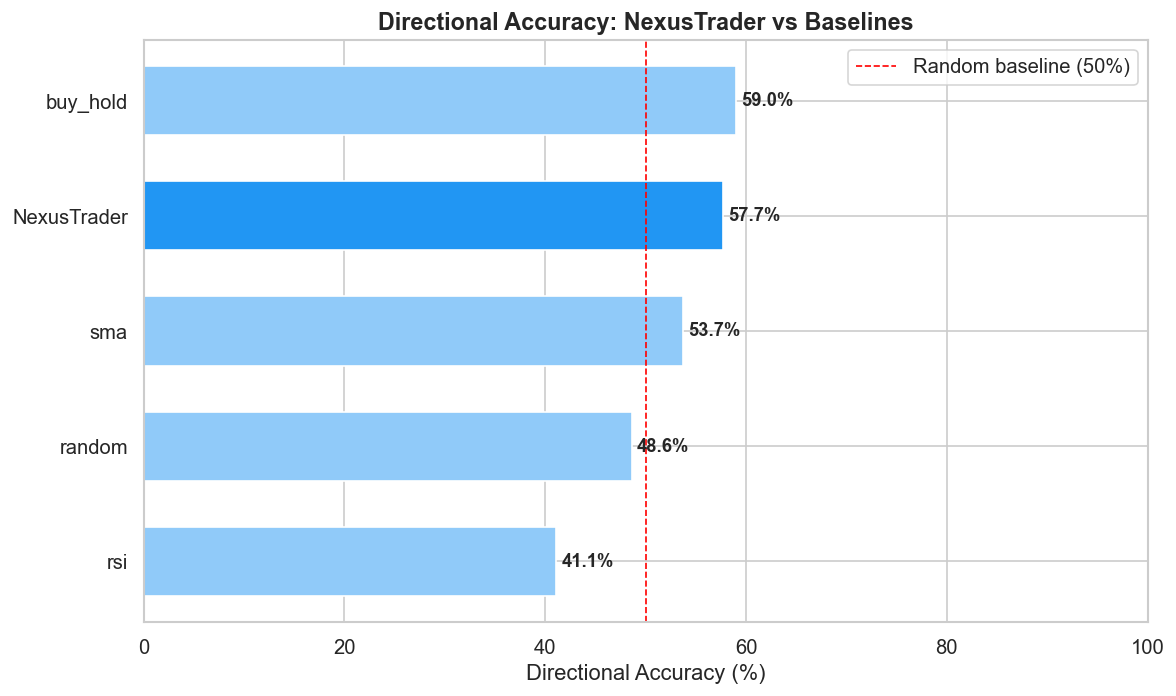

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

order = summary.sort_values("accuracy_%", ascending=True)["strategy"].tolist()
colors = ["#2196F3" if s == "NexusTrader" else "#90CAF9" for s in order]

bars = ax.barh(order, [summary.set_index("strategy").loc[s, "accuracy_%"] or 0 for s in order], color=colors, edgecolor="white", height=0.6)

# Value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{width:.1f}%", va="center", fontweight="bold", fontsize=11)

ax.axvline(50, color="red", linestyle="--", linewidth=1, label="Random baseline (50%)")
ax.set_xlabel("Directional Accuracy (%)")
ax.set_title("Directional Accuracy: NexusTrader vs Baselines", fontweight="bold", fontsize=14)
ax.legend()
ax.set_xlim(0, 100)
plt.tight_layout()
fig.savefig(CHARTS_DIR / "accuracy_by_strategy.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'accuracy_by_strategy.png'}")
plt.show()

## 8. Chart 2 — Coverage (Non-HOLD %) by Strategy

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\coverage_by_strategy.png


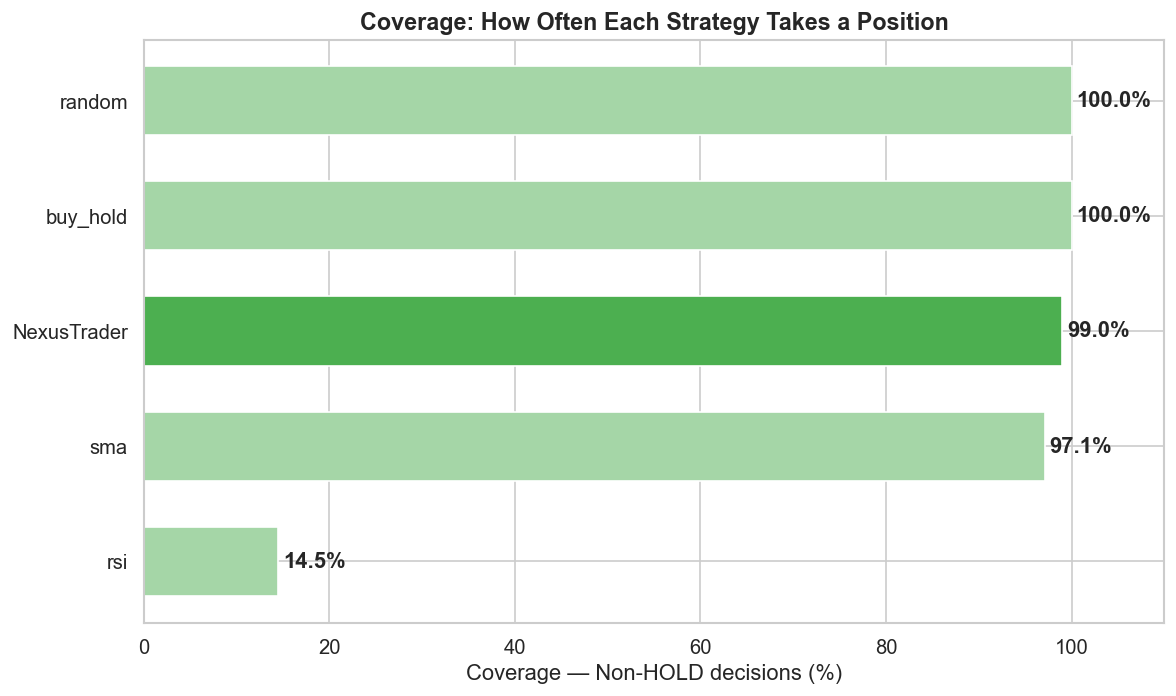

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

cov = summary.sort_values("coverage_%", ascending=True)
colors_cov = ["#4CAF50" if s == "NexusTrader" else "#A5D6A7" for s in cov["strategy"]]

bars = ax.barh(cov["strategy"], cov["coverage_%"], color=colors_cov, edgecolor="white", height=0.6)
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{width:.1f}%", va="center", fontweight="bold")

ax.set_xlabel("Coverage — Non-HOLD decisions (%)")
ax.set_title("Coverage: How Often Each Strategy Takes a Position", fontweight="bold", fontsize=14)
ax.set_xlim(0, 110)
plt.tight_layout()
fig.savefig(CHARTS_DIR / "coverage_by_strategy.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'coverage_by_strategy.png'}")
plt.show()

## 9. Chart 3 — Boxplot of Strategy Returns

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\returns_boxplot.png


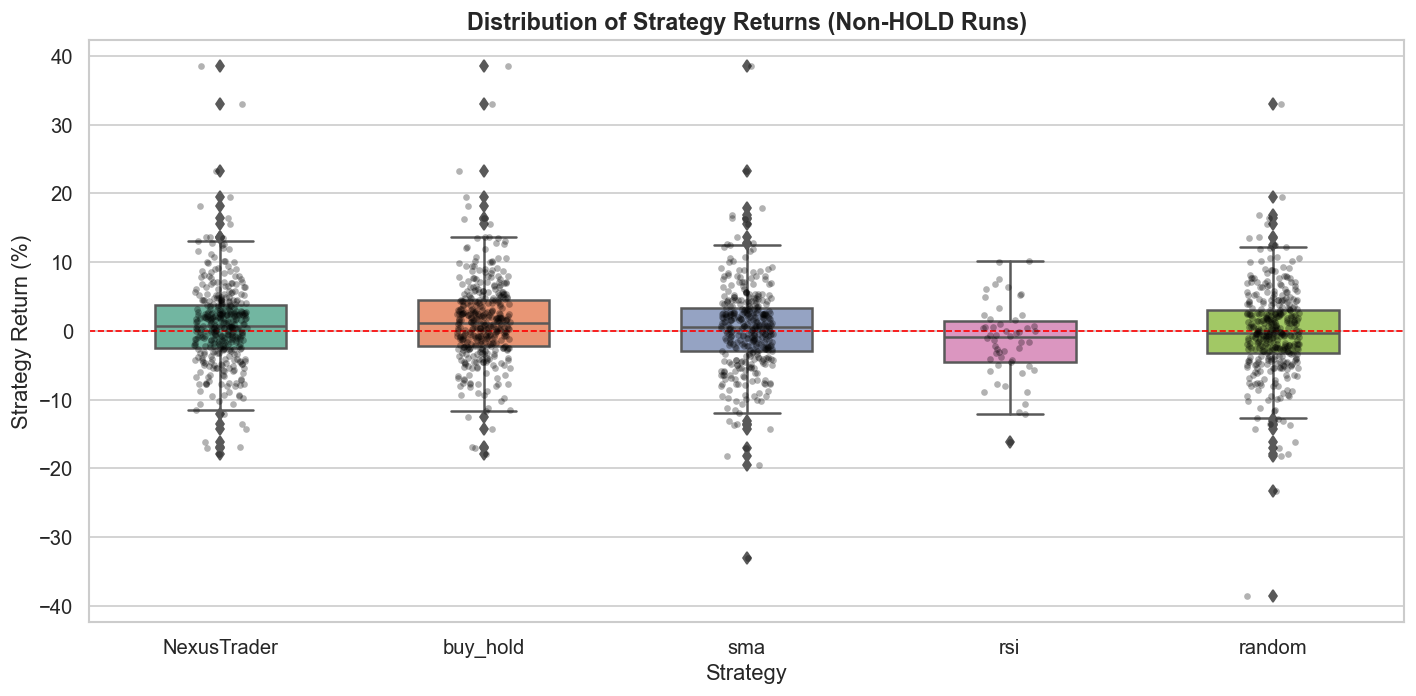

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

# Filter to scored non-HOLD runs only
df_scored = df_all[(df_all["action"] != "HOLD") & df_all["strategy_return"].notna()].copy()
df_scored["strategy_return_pct"] = df_scored["strategy_return"] * 100

strategy_order = ["NexusTrader", "buy_hold", "sma", "rsi", "random"]
existing_order = [s for s in strategy_order if s in df_scored["strategy"].unique()]

sns.boxplot(
    data=df_scored, x="strategy", y="strategy_return_pct",
    order=existing_order, palette="Set2", ax=ax, width=0.5
)
# Overlay individual points
sns.stripplot(
    data=df_scored, x="strategy", y="strategy_return_pct",
    order=existing_order, color="black", alpha=0.3, size=4, ax=ax, jitter=True
)

ax.axhline(0, color="red", linestyle="--", linewidth=1)
ax.set_xlabel("Strategy")
ax.set_ylabel("Strategy Return (%)")
ax.set_title("Distribution of Strategy Returns (Non-HOLD Runs)", fontweight="bold", fontsize=14)
plt.tight_layout()
fig.savefig(CHARTS_DIR / "returns_boxplot.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'returns_boxplot.png'}")
plt.show()

## 10. Chart 4 — Accuracy Heatmap (Ticker × Strategy)

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\accuracy_heatmap.png


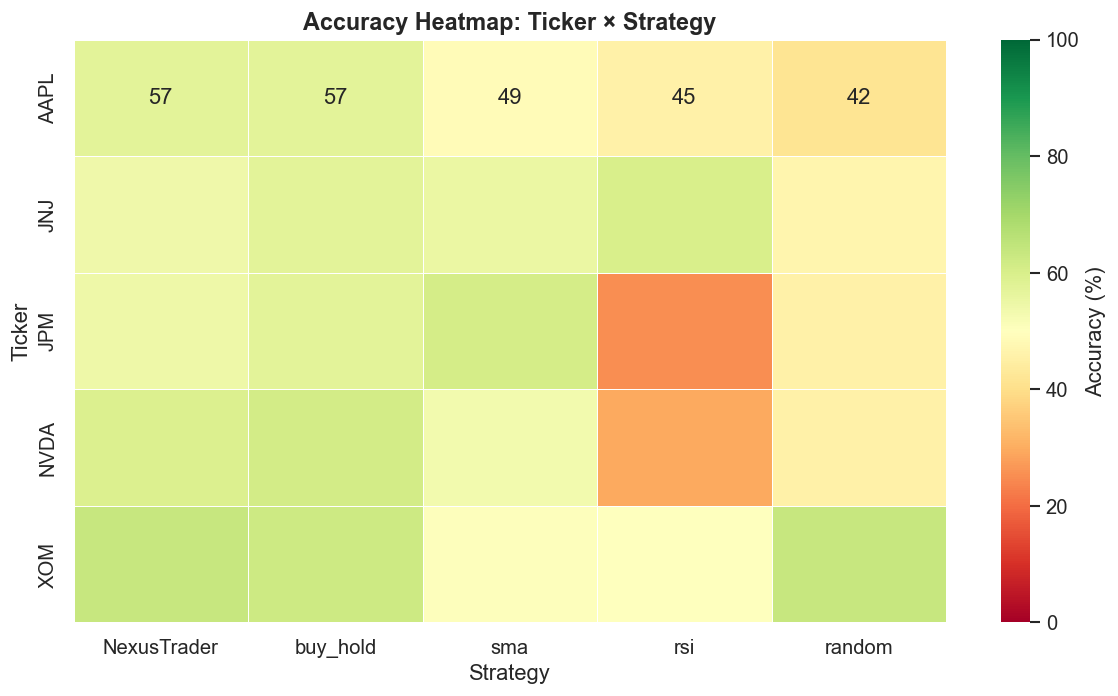

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Pivot: accuracy per (ticker, strategy)
df_nonhold = df_all[(df_all["action"] != "HOLD") & df_all["correct"].notna()].copy()
pivot = df_nonhold.groupby(["ticker", "strategy"])["correct"].mean().unstack(fill_value=np.nan) * 100

# Reorder columns
col_order = [c for c in ["NexusTrader", "buy_hold", "sma", "rsi", "random"] if c in pivot.columns]
pivot = pivot[col_order]

sns.heatmap(
    pivot, annot=True, fmt=".0f", cmap="RdYlGn", vmin=0, vmax=100,
    linewidths=0.5, cbar_kws={"label": "Accuracy (%)"}, ax=ax
)
ax.set_title("Accuracy Heatmap: Ticker × Strategy", fontweight="bold", fontsize=14)
ax.set_ylabel("Ticker")
ax.set_xlabel("Strategy")
plt.tight_layout()
fig.savefig(CHARTS_DIR / "accuracy_heatmap.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'accuracy_heatmap.png'}")
plt.show()

## 11. Chart 5 — Accuracy by Horizon (k = 10, 21, 126)

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\accuracy_by_horizon.png


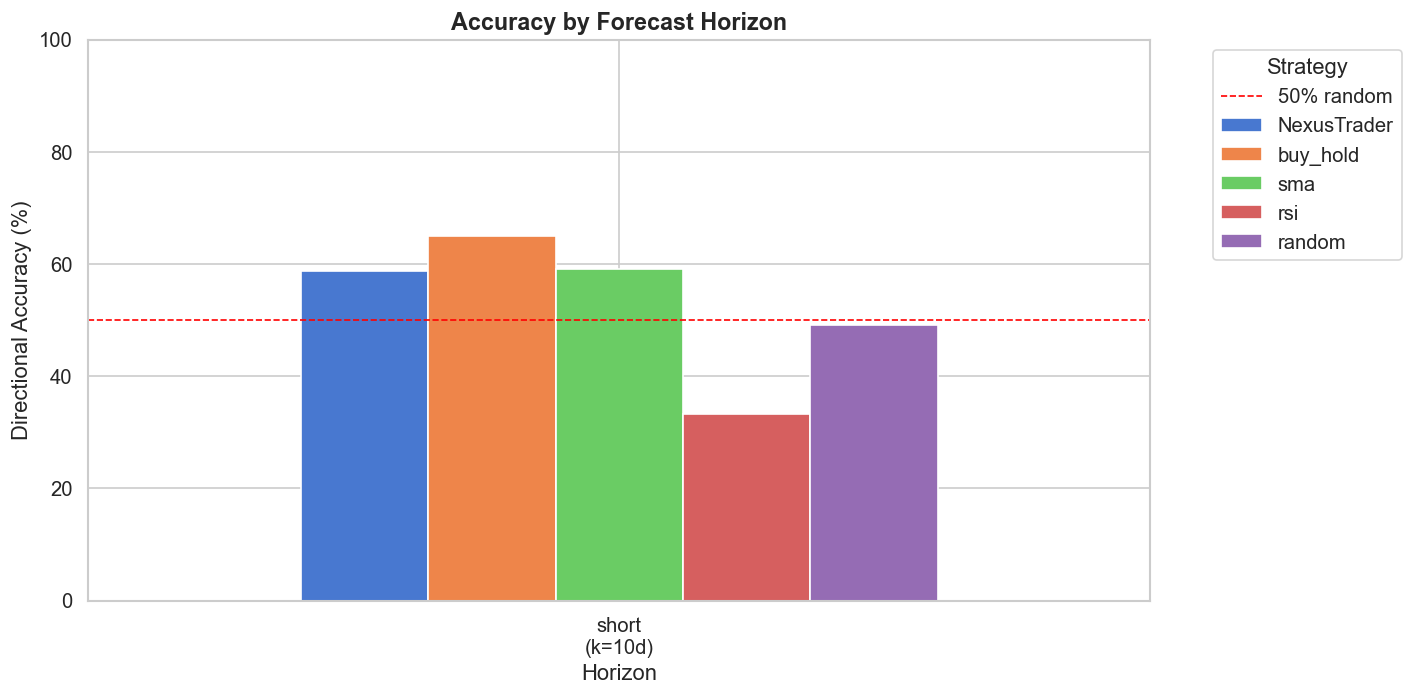

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

# Grouped accuracy by (horizon, strategy)
df_h = df_all[(df_all["action"] != "HOLD") & df_all["correct"].notna()].copy()
grouped = df_h.groupby(["horizon", "strategy"])["correct"].mean().reset_index()
grouped["accuracy_%"] = grouped["correct"] * 100

# Pivot for grouped bars
piv = grouped.pivot(index="horizon", columns="strategy", values="accuracy_%")
horizon_order = ["short", "medium", "long"]
piv = piv.reindex([h for h in horizon_order if h in piv.index])

col_order = [c for c in ["NexusTrader", "buy_hold", "sma", "rsi", "random"] if c in piv.columns]
piv = piv[col_order]

piv.plot(kind="bar", ax=ax, width=0.75, edgecolor="white")
ax.axhline(50, color="red", linestyle="--", linewidth=1, label="50% random")
ax.set_xlabel("Horizon")
ax.set_ylabel("Directional Accuracy (%)")
ax.set_title("Accuracy by Forecast Horizon", fontweight="bold", fontsize=14)
ax.set_xticklabels([f"{h}\n(k={HORIZONS[h]}d)" for h in piv.index], rotation=0)
ax.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylim(0, 100)
plt.tight_layout()
fig.savefig(CHARTS_DIR / "accuracy_by_horizon.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'accuracy_by_horizon.png'}")
plt.show()

## 12. Equity Curve — Cumulative Returns by Strategy

This approximates an equity curve by applying the per-run strategy returns in chronological order. For a clearer curve, we filter to one horizon (default: `medium`, k=10) and average returns across tickers on the same date.

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\equity_curve_short.png


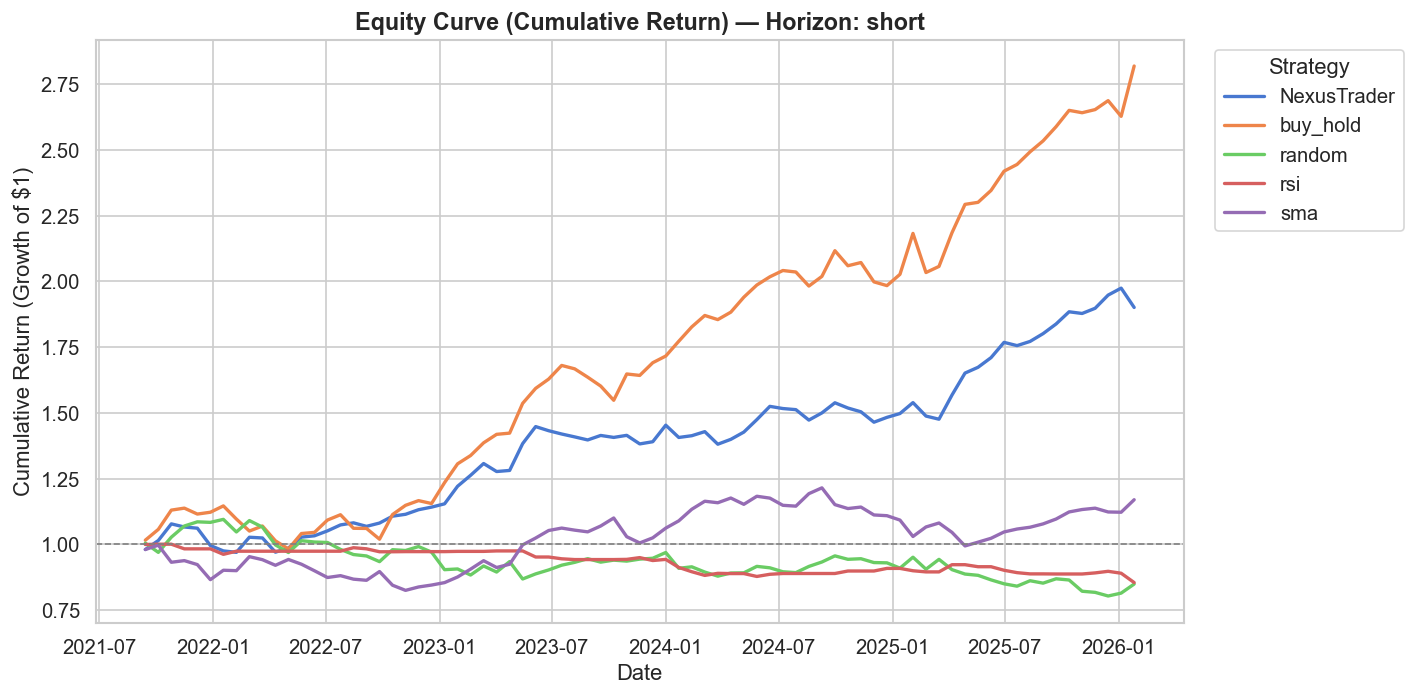

In [18]:
# --- Equity curve config ---
EQUITY_HORIZON = "short"  # choose from: short | medium | long

# Filter to chosen horizon and valid returns
curve_df = df_all[(df_all["horizon"] == EQUITY_HORIZON) & df_all["strategy_return"].notna()].copy()

# Aggregate by date (mean across tickers) to build a time series per strategy
curve_df["simulated_date"] = pd.to_datetime(curve_df["simulated_date"])
curve_df = curve_df.sort_values("simulated_date")

agg = (
    curve_df.groupby(["strategy", "simulated_date"])["strategy_return"]
    .mean()
    .reset_index()
)

# Build cumulative equity curve per strategy
fig, ax = plt.subplots(figsize=(12, 6))

for strategy, grp in agg.groupby("strategy"):
    grp = grp.sort_values("simulated_date")
    cum = (1 + grp["strategy_return"]).cumprod()
    ax.plot(grp["simulated_date"], cum, label=strategy, linewidth=2)

ax.set_title(f"Equity Curve (Cumulative Return) — Horizon: {EQUITY_HORIZON}", fontweight="bold", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return (Growth of $1)")
ax.axhline(1.0, color="gray", linestyle="--", linewidth=1)
ax.legend(title="Strategy", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

out_path = CHARTS_DIR / f"equity_curve_{EQUITY_HORIZON}.png"
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved → {out_path}")
plt.show()

## 13. Export Summary Tables & Final Report

All outputs are saved to the `experiments/` folder:
- `results/raw/` — raw JSONL from each strategy
- `results/scored/` — per-run and aggregate CSV
- `charts/` — PNG charts ready for the FYP report

In [ ]:
# ====  Final summary  ====
print("=" * 60)
print("  EXPERIMENT SUMMARY")
print("=" * 60)
print(f"\n  Matrix:   {len(TICKERS)} tickers × {len(SIMULATED_DATES)} dates × {len(HORIZONS)} horizons")
print(f"  Total:    {len(df_all)} scored runs across {df_all['strategy'].nunique()} strategies\n")

# Headline metrics
print("  Strategy            | Accuracy  | Coverage  | Mean Return")
print("  " + "-" * 56)
for _, row in summary.iterrows():
    acc = f"{row['accuracy_%']:.1f}%" if pd.notna(row['accuracy_%']) else "N/A"
    cov = f"{row['coverage_%']:.1f}%"
    ret = f"{row['mean_return_%']:+.2f}%" if pd.notna(row['mean_return_%']) else "N/A"
    print(f"  {row['strategy']:<20s}| {acc:<10s}| {cov:<10s}| {ret}")

# Best performer
if summary["accuracy_%"].notna().any():
    best = summary.loc[summary["accuracy_%"].idxmax()]
    print(f"\n  🏆 Highest accuracy: {best['strategy']} ({best['accuracy_%']:.1f}%)")

print(f"\n  Files saved:")
print(f"    📄 {scores_path}")
print(f"    📄 {summary_path}")
print(f"    📊 {CHARTS_DIR / '*.png'}")
print("=" * 60)

## 14. V3 Architecture Deep-Dive — Trader Independence & Risk Gate Analysis

In [33]:
# ============================================================
# V3 DEEP-DIVE ANALYSIS
# ============================================================
import re

print("=" * 70)
print("  V3 ARCHITECTURE ANALYSIS — Trader Independence & Risk Gate")
print("=" * 70)

# --- 1. Per-ticker accuracy for NexusTrader ---
df_nt = df_all[(df_all["strategy"] == "NexusTrader") & df_all["correct"].notna()].copy()
df_nt_nonhold = df_nt[df_nt["action"] != "HOLD"]

print("\n📊 1. PER-TICKER ACCURACY (NexusTrader)")
print("-" * 50)
for ticker, grp in df_nt_nonhold.groupby("ticker"):
    acc = grp["correct"].mean() * 100
    n = len(grp)
    buys = (grp["action"] == "BUY").sum()
    sells = (grp["action"] == "SELL").sum()
    print(f"  {ticker:<6s}: {acc:5.1f}%  ({n} scored | BUY={buys}, SELL={sells})")

total_acc = df_nt_nonhold["correct"].mean() * 100
print(f"  {'TOTAL':<6s}: {total_acc:5.1f}%  ({len(df_nt_nonhold)} scored)")

# --- 2. Action distribution ---
print(f"\n📊 2. ACTION DISTRIBUTION (NexusTrader)")
print("-" * 50)
action_counts = df_nt["action"].value_counts()
for action, count in action_counts.items():
    pct = count / len(df_nt) * 100
    print(f"  {action}: {count} ({pct:.1f}%)")

# --- 3. Per-action accuracy ---
print(f"\n📊 3. PER-ACTION ACCURACY")
print("-" * 50)
for action in ["BUY", "SELL", "HOLD"]:
    subset = df_nt[df_nt["action"] == action]
    scored = subset.dropna(subset=["correct"])
    if len(scored) > 0:
        acc = scored["correct"].mean() * 100
        print(f"  {action}: {acc:.1f}%  ({len(scored)} scored)")
    else:
        print(f"  {action}: N/A (0 scored)")

# --- 4. Trader Independence — parse JSONL for disagreements ---
print(f"\n📊 4. TRADER INDEPENDENCE (from batch JSONL metadata)")
print("-" * 50)

trader_agreed = 0
trader_disagreed = 0
risk_overrides = 0
risk_total = 0
disagreement_details = []

with open(BATCH_JSONL, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        row = json.loads(line)
        result = row.get("result", {})
        meta = result.get("run_metadata", {})
        
        rm_action = meta.get("research_manager_action")
        trader_action = meta.get("strategy_action")
        risk_orig = meta.get("risk_original_action")
        risk_final = meta.get("risk_final_action")
        disagreed = meta.get("trader_disagreed_with_manager", False)
        risk_overrode = meta.get("risk_overrode_action", False)
        
        if rm_action and trader_action:
            if disagreed:
                trader_disagreed += 1
                disagreement_details.append({
                    "ticker": row.get("ticker"),
                    "date": row.get("simulated_date"),
                    "rm": rm_action,
                    "trader": trader_action,
                    "risk_final": risk_final,
                })
            else:
                trader_agreed += 1
        
        if risk_orig and risk_final:
            risk_total += 1
            if risk_overrode:
                risk_overrides += 1

total_decisions = trader_agreed + trader_disagreed
if total_decisions > 0:
    disagree_pct = trader_disagreed / total_decisions * 100
    print(f"  Trader agreed with RM:    {trader_agreed}/{total_decisions} ({100-disagree_pct:.1f}%)")
    print(f"  Trader DISAGREED with RM: {trader_disagreed}/{total_decisions} ({disagree_pct:.1f}%)")
else:
    print("  ⚠️ No metadata found — run_metadata may not be populated")

# --- 5. Risk Gate overrides ---
print(f"\n📊 5. RISK GATE BEHAVIOR")
print("-" * 50)
if risk_total > 0:
    override_pct = risk_overrides / risk_total * 100
    print(f"  Risk evaluations: {risk_total}")
    print(f"  Risk overrides:   {risk_overrides}/{risk_total} ({override_pct:.1f}%)")
else:
    print("  ⚠️ No risk metadata found")

# --- 6. Disagreement outcomes ---
if disagreement_details:
    print(f"\n📊 6. DISAGREEMENT DETAILS ({len(disagreement_details)} cases)")
    print("-" * 70)
    print(f"  {'Ticker':<6s} {'Date':<12s} {'RM':<6s} {'Trader':<8s} {'Risk Final':<10s} {'Who Won?'}")
    print("  " + "-" * 64)
    
    rm_won = 0
    trader_won = 0
    neither = 0
    
    for d in disagreement_details:
        risk_final = d.get("risk_final", "?")
        if risk_final == d["rm"]:
            winner = "RM"
            rm_won += 1
        elif risk_final == d["trader"]:
            winner = "Trader"
            trader_won += 1
        else:
            winner = "Neither"
            neither += 1
        print(f"  {d['ticker']:<6s} {d['date']:<12s} {d['rm']:<6s} {d['trader']:<8s} {str(risk_final):<10s} {winner}")
    
    print(f"\n  Summary: RM won {rm_won}, Trader won {trader_won}, Neither {neither}")

# --- 7. V2 → V3 comparison ---
print(f"\n📊 7. VERSION COMPARISON")
print("-" * 50)
print(f"  {'Metric':<30s} {'V2':>8s} {'V3':>8s} {'Delta':>8s}")
print("  " + "-" * 54)

v2_acc = 59.6
v3_acc = total_acc
v2_random = 52.5
v3_random = summary[summary["strategy"] == "random"]["accuracy_%"].values[0] if len(summary[summary["strategy"] == "random"]) > 0 else None
v2_buyhold = 65.0
v3_buyhold = summary[summary["strategy"] == "buy_hold"]["accuracy_%"].values[0] if len(summary[summary["strategy"] == "buy_hold"]) > 0 else None

print(f"  {'NexusTrader accuracy':<30s} {v2_acc:>7.1f}% {v3_acc:>7.1f}% {v3_acc-v2_acc:>+7.1f}pp")
if v3_random is not None:
    print(f"  {'Random baseline':<30s} {v2_random:>7.1f}% {v3_random:>7.1f}% {v3_random-v2_random:>+7.1f}pp")
if v3_buyhold is not None:
    print(f"  {'Buy & Hold baseline':<30s} {v2_buyhold:>7.1f}% {v3_buyhold:>7.1f}% {v3_buyhold-v2_buyhold:>+7.1f}pp")

# Trader independence (v2 had 0% disagree)
if total_decisions > 0:
    print(f"  {'Trader disagree rate':<30s} {'0.0%':>8s} {disagree_pct:>7.1f}% {disagree_pct:>+7.1f}pp")
    print(f"  {'Risk override rate':<30s} {'0.0%':>8s} {override_pct:>7.1f}% {override_pct:>+7.1f}pp")

print("\n" + "=" * 70)

  V3 ARCHITECTURE ANALYSIS — Trader Independence & Risk Gate

📊 1. PER-TICKER ACCURACY (NexusTrader)
--------------------------------------------------
  AAPL  :  60.9%  (23 scored | BUY=12, SELL=11)
  JPM   :  70.8%  (24 scored | BUY=15, SELL=9)
  MSFT  :  45.8%  (24 scored | BUY=18, SELL=6)
  NVDA  :  75.0%  (24 scored | BUY=24, SELL=0)
  XOM   :  41.7%  (24 scored | BUY=13, SELL=11)
  TOTAL :  58.8%  (119 scored)

📊 2. ACTION DISTRIBUTION (NexusTrader)
--------------------------------------------------
  BUY: 82 (68.3%)
  SELL: 37 (30.8%)
  HOLD: 1 (0.8%)

📊 3. PER-ACTION ACCURACY
--------------------------------------------------
  BUY: 67.1%  (82 scored)
  SELL: 40.5%  (37 scored)
  HOLD: 0.0%  (1 scored)

📊 4. TRADER INDEPENDENCE (from batch JSONL metadata)
--------------------------------------------------
  ⚠️ No metadata found — run_metadata may not be populated

📊 5. RISK GATE BEHAVIOR
--------------------------------------------------
  ⚠️ No risk metadata found

📊 7. VERSIO